In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from utils.prepare_dataset import load_data
import matplotlib.pyplot as plt
import copy
import pickle
import os
import time
import sys
import argparse

In [26]:
trainloader, validloader = load_data('../images/', phase='train', batch_size=32)
testloader = load_data('../images/', phase='test', batch_size=32)

In [5]:
model = torchvision.models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features        
model.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\therealvietcong1337/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.0007)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
model = model.to(device)  
criterion = nn.CrossEntropyLoss()

In [9]:
def train(model, iterator, criterion, optimizer):
    
    global device
    epoch_loss, epoch_acc = 0, []    
    model.train()
    
    for batch in iterator:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels.reshape((32,)).long())
        correct, incorrect = 0, 0
        for p in range(inputs.size(0)):
            a = []
            for j in preds[p]:
                a.append(float(j.detach()))
            pred = a.index(max(a))
            if pred == int(labels[p]):
                correct = correct + 1
            else:
                incorrect = incorrect + 1
        accuracy = correct / (correct + incorrect)
        epoch_acc.append(accuracy) 
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator), np.mean(epoch_acc)

In [10]:
def evaluate(model, iterator, criterion): 
    global device
    epoch_loss, epoch_acc = 0, []
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            preds = model(inputs)
            loss = criterion(preds, labels)
            correct, incorrect = 0, 0
            for p in range(inputs.size(0)):
                a = []
                for j in preds[p]:
                    a.append(float(j.detach()))
                pred = a.index(max(a))
                if pred == int(labels[p]):
                    correct = correct + 1
                else:
                    incorrect = incorrect + 1
            epoch_loss += loss.item()
            accuracy = correct / (correct + incorrect)
            epoch_acc.append(accuracy) 
    return epoch_loss / len(iterator), np.mean(epoch_acc)

In [11]:
def epoch_time(start_time, end_time):
    '''
    compute elapsed time for training
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
os.makedirs('../trained_models', exist_ok=True)

In [13]:
best_valid_loss = float('inf')
best_valid_acc = 0.80
losses = []
for epoch in range(100):
    start_time = time.time()
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)
    losses.append(train_loss)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        print('model copied')
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), '../trained_models/' + 'resnet50_best.pt')
        
    if epoch >= 10 and train_loss >= losses[-1]:
            print('Early stopping')
            break

Epoch: 01 | Epoch Time: 1m 51s
	Train Loss: 0.193 | Train Acc: 95.91%
	 Val. Loss: 0.106 |  Val. Acc: 96.91%
model copied
Epoch: 02 | Epoch Time: 2m 5s
	Train Loss: 0.099 | Train Acc: 96.15%
	 Val. Loss: 0.059 |  Val. Acc: 97.75%
model copied
Epoch: 03 | Epoch Time: 2m 39s
	Train Loss: 0.069 | Train Acc: 97.36%
	 Val. Loss: 0.047 |  Val. Acc: 98.11%
model copied
Epoch: 04 | Epoch Time: 2m 48s
	Train Loss: 0.056 | Train Acc: 98.08%
	 Val. Loss: 0.038 |  Val. Acc: 98.63%
model copied
Epoch: 05 | Epoch Time: 3m 10s
	Train Loss: 0.047 | Train Acc: 98.27%
	 Val. Loss: 0.034 |  Val. Acc: 98.83%
model copied
Epoch: 06 | Epoch Time: 2m 33s
	Train Loss: 0.048 | Train Acc: 98.41%
	 Val. Loss: 0.036 |  Val. Acc: 98.60%
Epoch: 07 | Epoch Time: 1m 46s
	Train Loss: 0.037 | Train Acc: 98.75%
	 Val. Loss: 0.035 |  Val. Acc: 98.67%
Epoch: 08 | Epoch Time: 1m 38s
	Train Loss: 0.030 | Train Acc: 98.80%
	 Val. Loss: 0.035 |  Val. Acc: 98.60%
Epoch: 09 | Epoch Time: 1m 37s
	Train Loss: 0.040 | Train Acc: 9

### Testing

In [14]:
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
testloader = load_data(data_folder='../images', batch_size=20, phase='test')

In [28]:
acc = 0
lbls, predictions = [], []
with torch.no_grad():
    for batch in testloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        preds = best_model(inputs)
        _, out = torch.max(preds, 1)
        loss = criterion(preds, labels)
        lbls.append(labels.cpu().numpy())
        predictions.append(labels.cpu().numpy())
        accuracy = torch.sum(out == labels.data).double() / labels.shape[0]
        acc += accuracy.item()
        
print(f'Test accuracy: {acc / len(testloader) * 100:.2f}%')

Test accuracy: 99.26%


In [34]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report([y for x in lbls for y in x], [y for x in predictions for y in x]))
print(roc_auc_score([y for x in lbls for y in x], [y for x in predictions for y in x]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      3100
   macro avg       1.00      1.00      1.00      3100
weighted avg       1.00      1.00      1.00      3100

1.0


In [17]:
def visualize_model(model, num_images= 64):
    global device
    class_names = ['covid', 'non-covid']
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images/8, 8, images_so_far, )
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j].permute(2,1,0).numpy().astype(np.uint8), )
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

C:\Users\therealvietcong1337\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


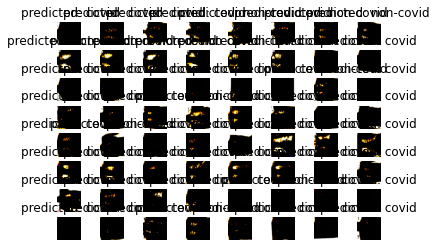

In [18]:
visualize_model(best_model)

In [36]:
type(device)

str